# A quick overview of the scans that Sebastien did a while ago
We retrieved them from the archive and now want to look at them

In [1]:
import platform
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches
import seaborn
import imageio
import pandas
import numpy
from tqdm import tqdm_notebook
from itkwidgets import view  # 3d viewer
import skimage

In [2]:
# Ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [4]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [5]:
# Display all plots identically
lines = 2
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [6]:
# Different locations if running either on Linux or Windows
FastSSD = False
# to speed things up significantly
if 'debian' in platform.dist():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', 'uCT-Archive-Online')
        
else:
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        BasePath = os.path.join('M:\\')
Root = os.path.join(BasePath, 'Rabbit-Grenoble')
print('We are loading all the data from %s' % Root)

We are loading all the data from /home/habi/uCT-Archive-Online/Rabbit-Grenoble


In [7]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [8]:
def get_reco_gray_level(logfile):
    """Get the gray level used for reconstructing the sample"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for CS' in line:
                graylevel = float(line.split('=')[1])
    return(graylevel)

In [9]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [10]:
# Get all folders
Data['Folder'] = glob.glob(os.path.join(Root, '*', '*'))

In [11]:
Data

,Folder
0,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...
1,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...
2,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...
3,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...
4,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...
5,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...
6,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...
7,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...
8,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...
9,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...


In [12]:
# Get rid of all non-folders
for c, i in Data.iterrows():
    if not os.path.isdir(i.Folder):
        Data.drop([c], inplace=True)

In [13]:
try:
    Data['Folder'][0]
except IndexError:
    print(10 * '\n')
    print('Please mount the Fast SSD!')
    print(10 * '\n')

In [21]:
Data['SampleName'] = [os.path.basename(f) for f in Data['Folder']]
Data['SampleNameLength'] = [len(r) for r in Data['SampleName']]

In [48]:
Data['Rabbit'] = [n.split('-')[1] for n in Data['SampleName']]
Data['Bone'] = '-'
for c,row in Data.iterrows():
    if 'Mandib' in row['SampleName']:
        Data['Bone'][c] = 'Mandibula'
    elif 'Maxi' in row['SampleName']:
        Data['Bone'][c] = 'Maxilla'        

In [49]:
# Get all log files
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log'))) for f in Data['Folder']]

In [50]:
Data

,index,Folder,Sample,SampleNameLength,Rabbit,Bone,LogFile,SampleName,Reconstructions,Number of reconstructions,Voxelsize,GrayLevel,OutputNameRec,Size,Mid_Axial,Mid_Sagittal,Mid_Coronal,MIP_Axial,MIP_Sagittal,MIP_Coronal
0,0,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...,Rabbit-1-Overview--Mandibula-Grenoble2015-26-6um,48,1,Mandibula,[/home/habi/uCT-Archive-Online/Rabbit-Grenoble...,Rabbit-1-Overview--Mandibula-Grenoble2015-26-6um,[/home/habi/uCT-Archive-Online/Rabbit-Grenoble...,2171,26.54,0.050,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...,"(2171, 1984, 1984)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 12, 8, 7,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 30, 34, 32, 44, 4...","[[0, 0, 0, 0, 0, 0, 0, 0, 57, 52, 61, 56, 66, ..."
1,1,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...,Rabbit-1-Overview-Maxilaris-Grenoble2015-13-3um,47,1,Maxilla,[/home/habi/uCT-Archive-Online/Rabbit-Grenoble...,Rabbit-1-Overview-Maxilaris-Grenoble2015-13-3um,[/home/habi/uCT-Archive-Online/Rabbit-Grenoble...,4371,13.27,0.050,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...,"(4371, 3968, 3968)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 49..."
2,2,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...,Rabbit-1-Overview-Maxilaris-Grenoble2015-26-6um,47,1,Maxilla,[/home/habi/uCT-Archive-Online/Rabbit-Grenoble...,Rabbit-1-Overview-Maxilaris-Grenoble2015-26-6um,[/home/habi/uCT-Archive-Online/Rabbit-Grenoble...,2117,26.54,0.050,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...,"(2117, 1984, 1984)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 26, 20, 19, 25, 22, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 17, 16, 18, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 34, 41, 41, 38, 36, ..."
3,3,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...,Rabbit-2-Grenoble2015-26-5um,28,2,-,[/home/habi/uCT-Archive-Online/Rabbit-Grenoble...,Rabbit-2-Grenoble2015-26-5um,[/home/habi/uCT-Archive-Online/Rabbit-Grenoble...,600,26.54,0.050,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...,"(600, 1984, 1984)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3, 7,...","[[0, 0, 0, 0, 0, 0, 0, 0, 9, 11, 15, 17, 15, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 23, 26, 25, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 28, 24, 22, 22, 23, ..."
4,4,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...,Rabbit-2-Overview-Grenoble2015-26-5um,37,2,-,[/home/habi/uCT-Archive-Online/Rabbit-Grenoble...,Rabbit-2-Overview-Grenoble2015-26-5um,[/home/habi/uCT-Archive-Online/Rabbit-Grenoble...,1707,26.54,0.050,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...,"(1707, 1984, 1984)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 12, 13, 6, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 9, 12, 19, 25, 25, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 23, 19, 28, 2...","[[0, 0, 0, 0, 0, 0, 0, 0, 29, 31, 36, 33, 27, ..."
5,19,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...,Rabbit-6-Overview-Mandibula-Grenoble2015-26-6um,47,6,Mandibula,[/home/habi/uCT-Archive-Online/Rabbit-Grenoble...,Rabbit-6-Overview-Mandibula-Grenoble2015-26-6um,[/home/habi/uCT-Archive-Online/Rabbit-Grenoble...,2375,26.54,0.041,/home/habi/uCT-Archive-Online/Rabbit-Grenoble/...,"(2375, 1984, 1984)","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 8, 12, 6, 0, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0,

In [25]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, 'rec', '*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [26]:
# Some datasets might not be reconstructed yet.
# Drop those, based on https://stackoverflow.com/a/27360130/323100
Data.drop(Data[Data['Number of reconstructions'] == 0].index, inplace=True)
# Reset index, so we can still count like we used to
Data.reset_index(inplace=True)

In [27]:
# Get only main log file and voxel size
Data['LogFile'] = [l[0] for l in Data.LogFile]
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['GrayLevel'] = [get_reco_gray_level(log) for log in Data['LogFile']]

In [28]:
# Display some info
for c, row in Data.iterrows():
    print('%02s/%s: %s has %04s reconstructions in %s/%s' % (c + 1,
                                                             len(Data),
                                                             row['SampleName'].rjust(Data['SampleNameLength'].max()),
                                                             row['Number of reconstructions'],
                                                             os.path.basename(row['Folder']),
                                                             'rec'))

 1/6: Rabbit-1-Overview--Mandibula-Grenoble2015-26-6um has 2171 reconstructions in Rabbit-1-Overview--Mandibula-Grenoble2015-26-6um/rec
 2/6:  Rabbit-1-Overview-Maxilaris-Grenoble2015-13-3um has 4371 reconstructions in Rabbit-1-Overview-Maxilaris-Grenoble2015-13-3um/rec
 3/6:  Rabbit-1-Overview-Maxilaris-Grenoble2015-26-6um has 2117 reconstructions in Rabbit-1-Overview-Maxilaris-Grenoble2015-26-6um/rec
 4/6:                     Rabbit-2-Grenoble2015-26-5um has  600 reconstructions in Rabbit-2-Grenoble2015-26-5um/rec
 5/6:            Rabbit-2-Overview-Grenoble2015-26-5um has 1707 reconstructions in Rabbit-2-Overview-Grenoble2015-26-5um/rec
 6/6:  Rabbit-6-Overview-Mandibula-Grenoble2015-26-6um has 2375 reconstructions in Rabbit-6-Overview-Mandibula-Grenoble2015-26-6um/rec


In [29]:
Data[['SampleName', 'Voxelsize', 'GrayLevel']]

,SampleName,Voxelsize,GrayLevel
0,Rabbit-1-Overview--Mandibula-Grenoble2015-26-6um,26.54,0.050
1,Rabbit-1-Overview-Maxilaris-Grenoble2015-13-3um,13.27,0.050
2,Rabbit-1-Overview-Maxilaris-Grenoble2015-26-6um,26.54,0.050
3,Rabbit-2-Grenoble2015-26-5um,26.54,0.050
4,Rabbit-2-Overview-Grenoble2015-26-5um,26.54,0.050
5,Rabbit-6-Overview-Mandibula-Grenoble2015-26-6um,26.54,0.041


In [30]:
# Convert all reconstructions into a single numpy array and them to disk
# But only do this if we didn't do it already :)
# Partially based on http://stackoverflow.com/a/39195332/323100
# Since we reload/memorymap the stack below, we overwrite the variable with NaN and clear the memory
Data['OutputNameRec'] = [os.path.join(f, sample + '_rec.npy') for f, sample in zip(Data.Folder, Data.Sample)]
# Don't save into the dataframe, or else we won't be able to make it :)
Reconstructions = [numpy.nan for file in Data['OutputNameRec']]
# Do it now
for c, row in Data.iterrows():
    if os.path.exists(row['OutputNameRec']):
        print('%2s/%s: %s: Loading reconstructions from %s' % (c + 1,
                                                               len(Data),
                                                               row['SampleName'].rjust(Data['SampleNameLength'].max()),
                                                               row['OutputNameRec']))
        Reconstructions[c] = numpy.load(row['OutputNameRec'], mmap_mode='r')
    else:
        print('%2s/%s: %s: Reading %04s reconstructions' % (c + 1,
                                                            len(Data),
                                                            row['SampleName'].rjust(Data['SampleNameLength'].max()),
                                                            row['Number of reconstructions']))
        # https://groups.google.com/forum/#!topic/imageio/O3TjIWKzd5Q
        Reconstructions[c] = numpy.stack([imageio.imread(rec,
                                                         ignoregamma=True) for rec in row['Reconstructions']], 0)
        print('%s: Saving to %s' % (row['SampleName'].rjust(Data['SampleNameLength'].max() + 6),
                                    row['OutputNameRec'][len(Root):]))
        numpy.save(row['OutputNameRec'], Reconstructions[c], allow_pickle=False)

 1/6: Rabbit-1-Overview--Mandibula-Grenoble2015-26-6um: Reading 2171 reconstructions
      Rabbit-1-Overview--Mandibula-Grenoble2015-26-6um: Saving to /Rabbit-1-Grenoble2015/Rabbit-1-Overview--Mandibula-Grenoble2015-26-6um/Rabbit-1-Overview--Mandibula-Grenoble2015-26-6um_rec.npy
 2/6:  Rabbit-1-Overview-Maxilaris-Grenoble2015-13-3um: Reading 4371 reconstructions
       Rabbit-1-Overview-Maxilaris-Grenoble2015-13-3um: Saving to /Rabbit-1-Grenoble2015/Rabbit-1-Overview-Maxilaris-Grenoble2015-13-3um/Rabbit-1-Overview-Maxilaris-Grenoble2015-13-3um_rec.npy
 3/6:  Rabbit-1-Overview-Maxilaris-Grenoble2015-26-6um: Reading 2117 reconstructions
       Rabbit-1-Overview-Maxilaris-Grenoble2015-26-6um: Saving to /Rabbit-1-Grenoble2015/Rabbit-1-Overview-Maxilaris-Grenoble2015-26-6um/Rabbit-1-Overview-Maxilaris-Grenoble2015-26-6um_rec.npy
 4/6:                     Rabbit-2-Grenoble2015-26-5um: Reading  600 reconstructions
                          Rabbit-2-Grenoble2015-26-5um: Saving to /Rabbit-2-Gre

In [31]:
# How big are the datasets?
Data['Size'] = [numpy.shape(rec) for rec in Reconstructions]

In [32]:
# Get ourselves the respective middle images
Data['Mid_Axial'] = [rec[numpy.shape(rec)[0] // 2, :, :] for rec in Reconstructions]
Data['Mid_Sagittal'] = [rec[:, numpy.shape(rec)[1] // 2, :] for rec in Reconstructions]
Data['Mid_Coronal'] = [rec[:, :, numpy.shape(rec)[2] // 2] for rec in Reconstructions]

In [33]:
# The three cardinal directions
directions = ['Axial', 'Sagittal', 'Coronal']

In [ ]:
# Show middle slices
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['Mid_' + direction],
                   vmax=row['Mid_' + direction].max() * .618)
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s/%s: %s, %s' % (c + 1,
                                     len(Data),
                                     'Rabbit ' + row['Rabbit'] + ': ' + row['Bone'],
                                     direction + ' Middle slice'))
        plt.axis('off')
    plt.tight_layout()        
    plt.savefig(os.path.join(row['Folder'],
                             row['SampleName'] + '.MiddleSlices.png'),
                bbox_inches='tight')
    plt.show()

In [35]:
# Calculate MIPs and put them into the dataframe
for c, direction in enumerate(directions):
    Data['MIP_' + direction] = [numpy.max(rec, axis=c) for rec in Reconstructions]

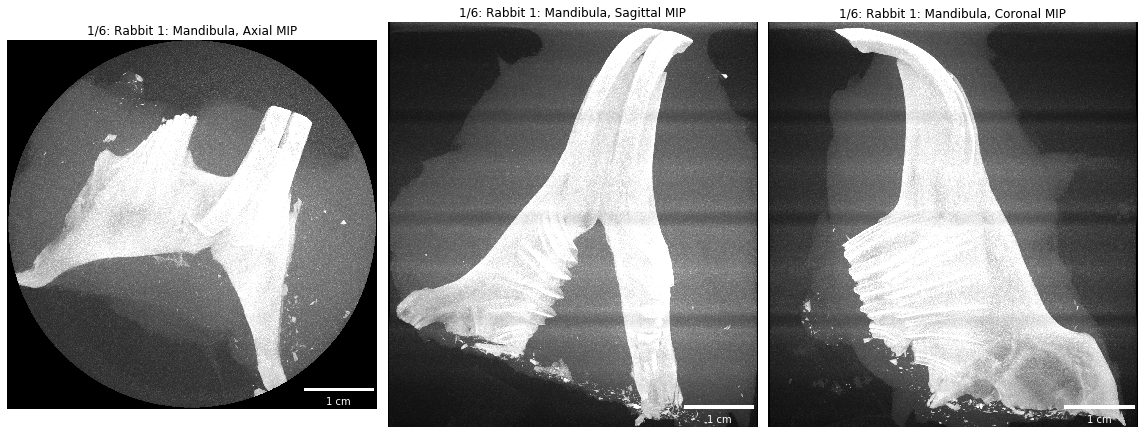

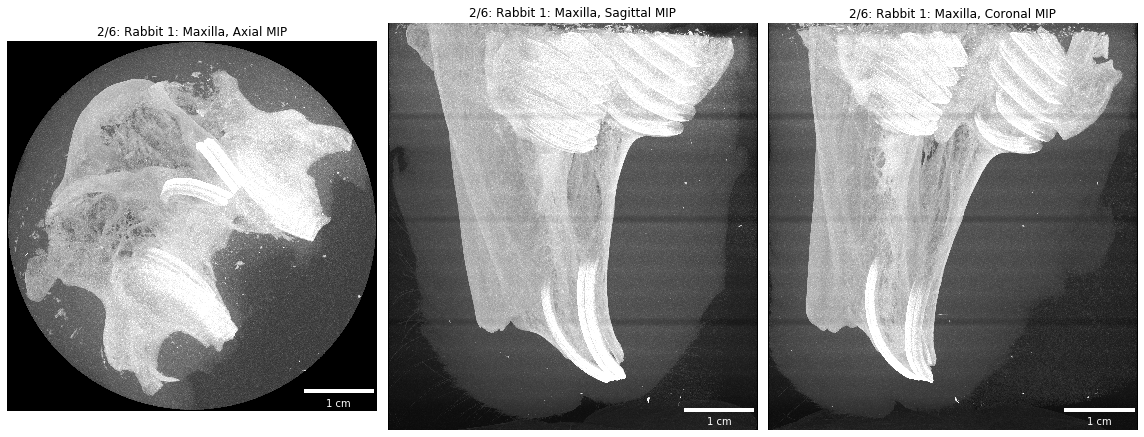

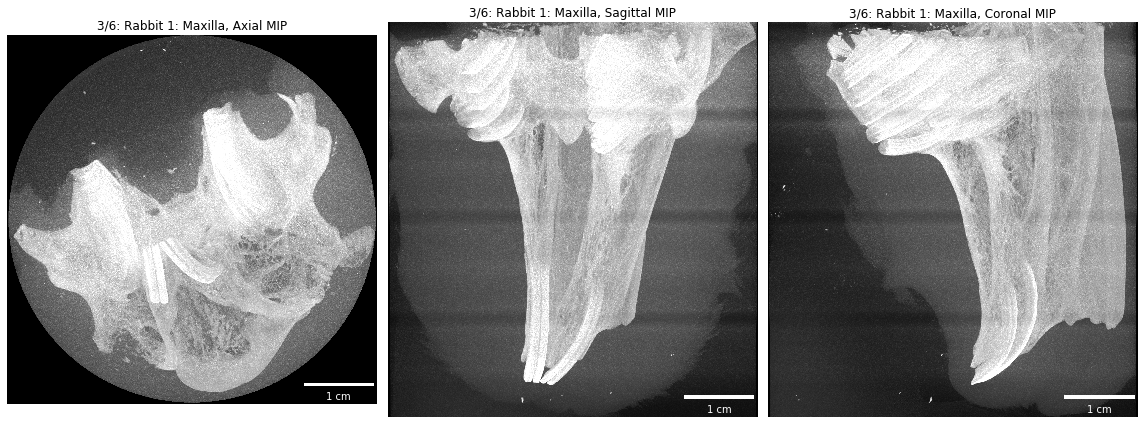

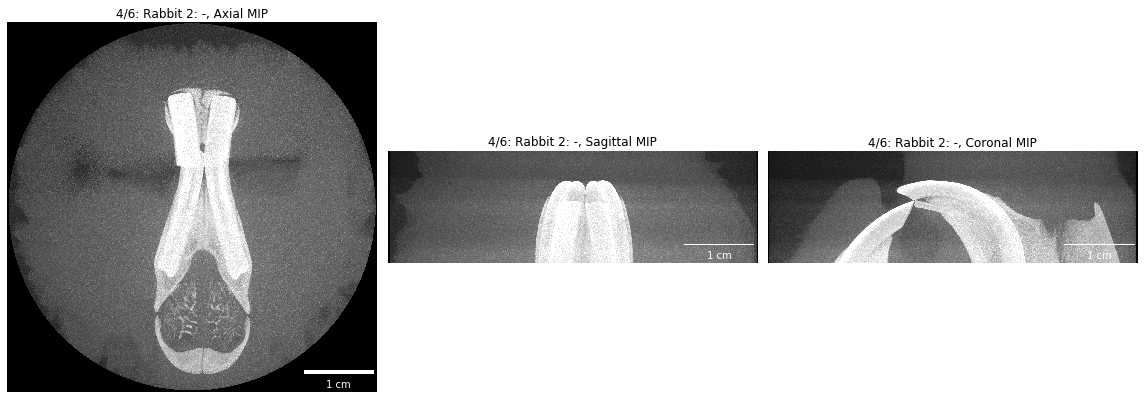

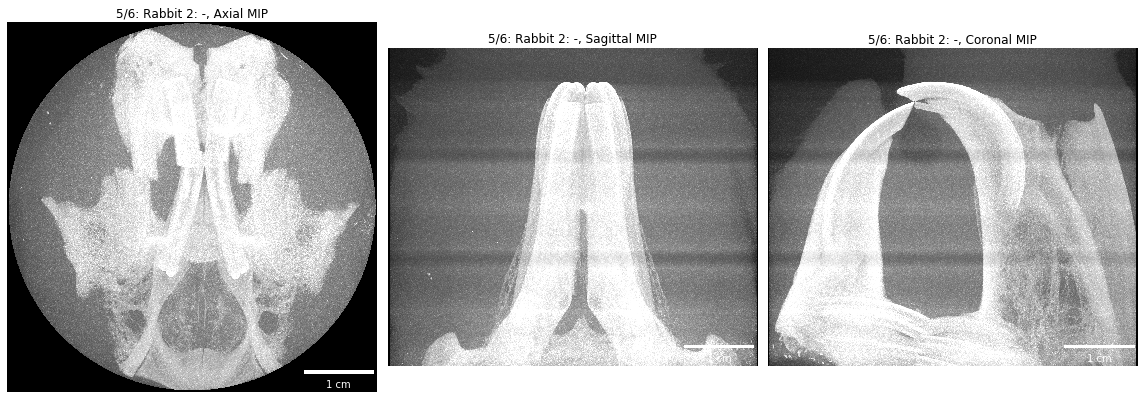

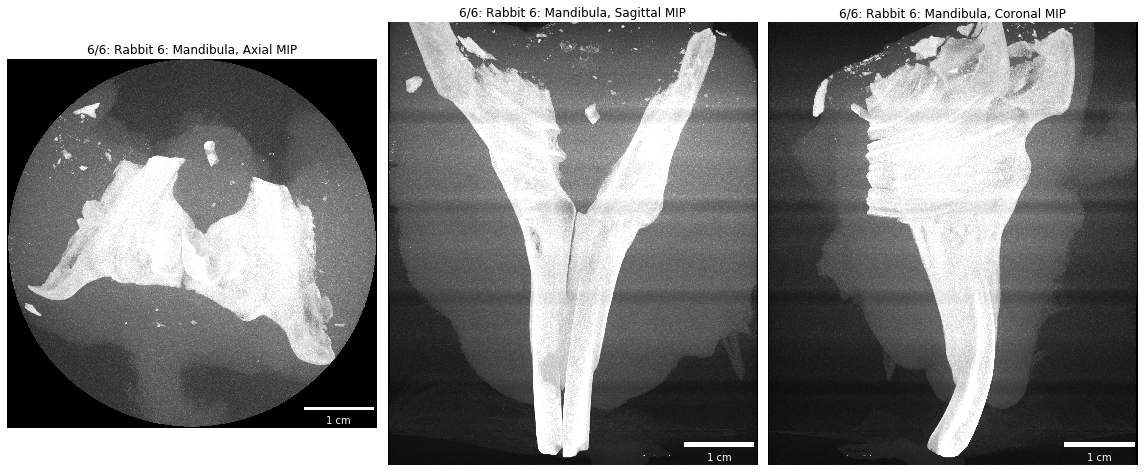

In [51]:
# Show MIP slices
for c, row in Data.iterrows():
    for d, direction in enumerate(directions):
        plt.subplot(1, 3, d + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s/%s: %s, %s' % (c + 1,
                                     len(Data),
                                     'Rabbit ' + row['Rabbit'] + ': ' + row['Bone'],
                                     direction + ' MIP'))
        plt.axis('off')
    plt.tight_layout()        
    plt.savefig(os.path.join(row['Folder'],
                             row['SampleName'] + '.MIPs.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# Show middle slices together
for d, direction in enumerate(directions):
    print(direction)
    for c, row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['Mid_' + direction],
                   vmax=row['Mid_' + direction].max() * .618)
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        if 'xial' in direction:
            recname = os.path.basename(row['Reconstructions'][row['Number of reconstructions'] // 2]).replace('0000',
                                                                                                              '')
            plt.title('%s/%s: %s' % (c + 1,
                                     len(Data),
                                     'Rabbit ' + row['Rabbit'] + ': ' + row['Bone'] + ' ...' + recname[-11:]))
        else:
            plt.title('%s/%s: %s, mid-%s slice' % (c + 1,
                                                   len(Data),
                                                   'Rabbit ' + row['Rabbit'] + ': ' + row['Bone'],
                                                   direction.lower()))
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(Root,
                             'MiddleSlices.' + direction + '.png'),
                bbox_inches='tight')
    plt.show()

In [ ]:
# Show MIPs together
for d, direction in enumerate(directions):
    print(direction)
    for c, row in Data.iterrows():
        plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
        plt.imshow(row['MIP_' + direction])
        plt.gca().add_artist(ScaleBar(row['Voxelsize'], 'um'))
        plt.title('%s/%s: %s, %s MIP' % (c + 1,
                                         len(Data),
                                         'Rabbit ' + row['Rabbit'] + ': ' + row['Bone'],
                                         direction.lower()))
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(Root, 'MIPs.' + direction + '.png'),
                bbox_inches='tight')
    plt.show()

In [39]:
# Save out the single middle slices to disk
for c, row in tqdm_notebook(Data.iterrows(), desc='Writing middle slices', total=len(Data)):
    for direction in tqdm_notebook(directions, desc=row['SampleName'], leave=True):
        outfilepath = os.path.join(row['Folder'], '%s.Middle.%s.png' % (row['SampleName'], direction))
        if not os.path.exists(outfilepath):
            imageio.imwrite(outfilepath, row['Mid_' + direction])

In [40]:
# Save out the single MIPs to disk
for c, row in tqdm_notebook(Data.iterrows(), desc='Writing MIPs', total=len(Data)):
    for direction in tqdm_notebook(directions, desc=row['SampleName'], leave=True):
        outfilepath = os.path.join(row['Folder'], '%s.MIP.%s.png' % (row['SampleName'], direction))
        if not os.path.exists(outfilepath):
            imageio.imwrite(outfilepath, row['MIP_' + direction])

In [41]:
len(Data)

6

In [42]:
whichone = 0
print(Data.Sample[whichone])
view(Reconstructions[whichone].astype('uint8'),
     ui_collapsed=True,
     annotations=False)

Rabbit-1-Overview--Mandibula-Grenoble2015-26-6um


Viewer(annotations=False, geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.…